In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import square, find_peaks
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

Text(0, 0.5, 'OD')

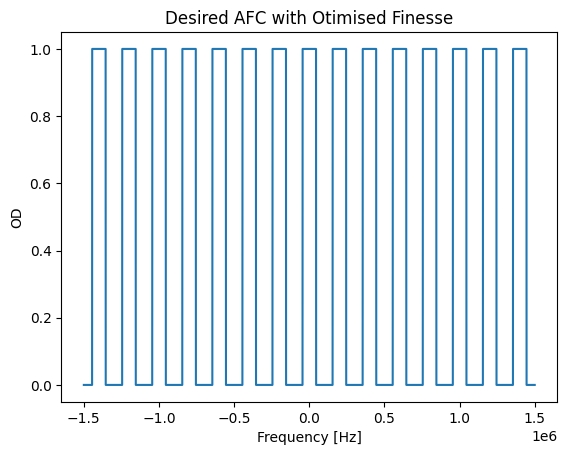

In [3]:
# AFC Parameter Calculation

OD = 1 # Optical depth of absorption
tau = 5e-6 # Storage time of AFC
Delta = 1/tau # AFC tooth seperation
F_opt = np.pi/(np.arctan((2*np.pi)/OD)) # Optimal finesse calculation
gamma = Delta/F_opt

samples = int(1e5)
f = 3E6 # absorption feature width
freq = np.linspace(-f/2,f/2,samples)

AFC = OD*(1+square(2*np.pi/Delta*freq+1*np.pi*gamma/Delta,gamma/Delta))/2 # AFC definition

plt.figure()
plt.plot(freq,AFC)
plt.title('Desired AFC with Otimised Finesse')
plt.xlabel('Frequency [Hz]')
plt.ylabel('OD')

Text(0, 0.5, 'Intensity (a.u.)')

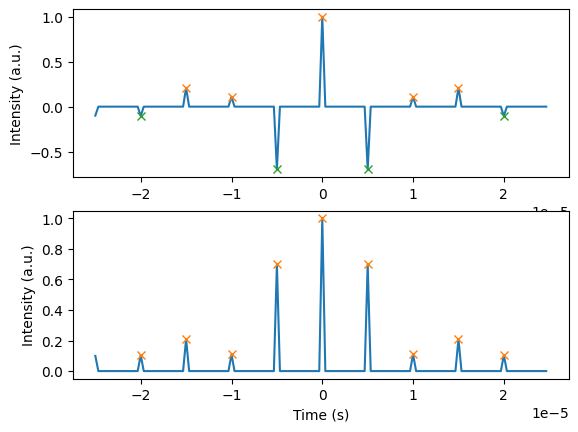

In [16]:
# Fourier Transform of AFC

AFC_train = ifftshift(ifft(AFC))
time = ifftshift(fftfreq(n=np.size(freq), d=f/samples))

train_width = 50e-6    # width of pulse train

idx_train = np.where((time >= -train_width/2) & (time < train_width/2))

peaks_abs,_ = find_peaks(np.abs(AFC_train[idx_train]), height = 0.01)
peaks,_ = find_peaks(np.real(AFC_train[idx_train]), height = 0.01)
valleys,_ = find_peaks(-np.real(AFC_train[idx_train]), height = 0.01)

Normal_peaks = 1/max(np.abs(AFC_train[idx_train][peaks_abs]))

plt.subplot(2,1,1)
plt.plot(time[idx_train],Normal_peaks*np.real(AFC_train[idx_train]))
plt.plot(time[idx_train][peaks],Normal_peaks*np.real(AFC_train[idx_train][peaks]),'x')
plt.plot(time[idx_train][valleys],Normal_peaks*np.real(AFC_train[idx_train][valleys]),'x')

plt.ylabel('Intensity (a.u.)')

plt.subplot(2,1,2)
plt.plot(time[idx_train],Normal_peaks*np.abs(AFC_train[idx_train]))
plt.plot(time[idx_train][peaks_abs],Normal_peaks*np.abs(AFC_train[idx_train][peaks_abs]),'x')

plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')

Text(0, 0.5, 'OD')

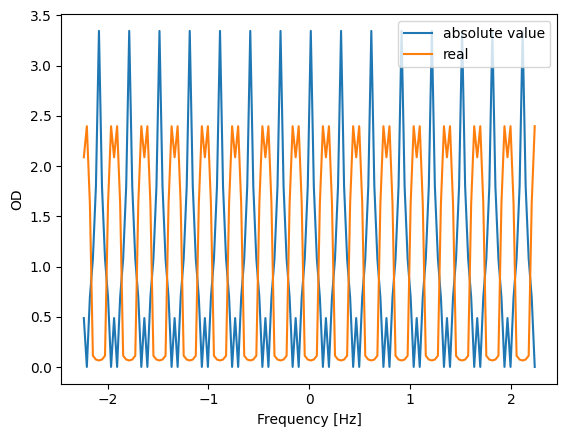

In [18]:
# AFC from Pulse Train

AFC_2 = fftshift(fft(Normal_peaks*np.real(AFC_train[idx_train])))
AFC_2_real_pos = fftshift
AFC_2_combined = fftshift(fft(Normal_peaks*np.abs(AFC_train[idx_train])))

plt.figure()

plt.plot(freq[idx_train],np.abs(AFC_2_combined))
plt.plot(freq[idx_train],np.abs(AFC_2))

plt.legend(['absolute value','real'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('OD')

32000


Text(0, 0.5, 'Intensity (a.u.)')

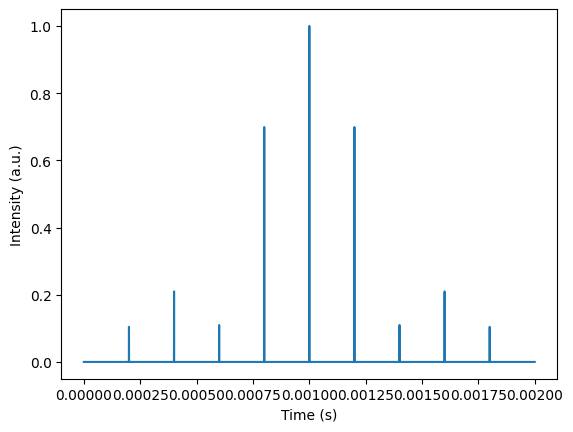

In [17]:
# Define AFC pulse sequence

sampling_rate = 2.4e9 # sampling rate of HDAWG

AFC_amplitude = 0.21 # Maximum amplitde of AFC pulse train
AFC_duration = 2e-3 # Total time of AFC pulse train
AFC_samples = round(AFC_duration*sampling_rate)
AFC_pulse_width = 500e-9 # Width of each pulse in the pulse train (defined from AOM response time)
AFC_pulse_width_samples = round(AFC_pulse_width*sampling_rate)

scaling_fact = int(AFC_samples/len(AFC_train[idx_train]))

print(scaling_fact)

def rect(T):
    #create a centered rectangular pulse of width $T
    return lambda t: (-T/2 <= t) & (t < T/2)

def pulse_train(t, at, A, shape):
    #create a train of pulses over $t at times $at and shape $shape
    return np.sum(A[:,np.newaxis]*shape(t - at[:,np.newaxis]), axis=0)

AFC_pulse_train = pulse_train(
    t = np.arange(AFC_samples),              # time domain
    at = scaling_fact*peaks_abs,  # times of pulses
    A = Normal_peaks*np.abs(AFC_train[idx_train][peaks_abs]),    # height of pulse
    shape=  rect(AFC_pulse_width_samples)                 # shape of pulse
)

plt.plot(np.linspace(0,AFC_duration,AFC_samples),AFC_pulse_train)
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')